
=== Train MLP ===
Epoch 0: loss=574.7893, val_loss=602.5715, val_mae=22.7754
Epoch 10: loss=65.1123, val_loss=61.7891, val_mae=6.1276
Epoch 20: loss=30.8520, val_loss=27.7633, val_mae=4.1922
Epoch 30: loss=26.1302, val_loss=23.3376, val_mae=3.6966
Epoch 40: loss=18.7029, val_loss=21.1291, val_mae=3.3892
Epoch 50: loss=19.6892, val_loss=21.5704, val_mae=3.2977
Early stopping tại epoch 58

Dự đoán cho ngôi nhà đầu tiên: 7.59 (nghìn USD)
MAE trên tập kiểm tra cuối cùng: 3.1837

=== K-Fold Validation MLP ===

--- Fold 1/4 ---
Epoch 0: loss=586.8365, val_loss=568.3532, val_mae=21.7022
Epoch 10: loss=165.8909, val_loss=107.9447, val_mae=8.3395
Epoch 20: loss=32.3584, val_loss=25.5347, val_mae=3.4393
Epoch 30: loss=27.7498, val_loss=21.0065, val_mae=3.2376
Epoch 40: loss=23.3735, val_loss=17.6923, val_mae=3.0367

--- Fold 2/4 ---
Epoch 0: loss=588.9969, val_loss=545.0709, val_mae=21.7502
Epoch 10: loss=108.0380, val_loss=71.8024, val_mae=6.8834
Epoch 20: loss=33.1885, val_loss=22.8314, val_m

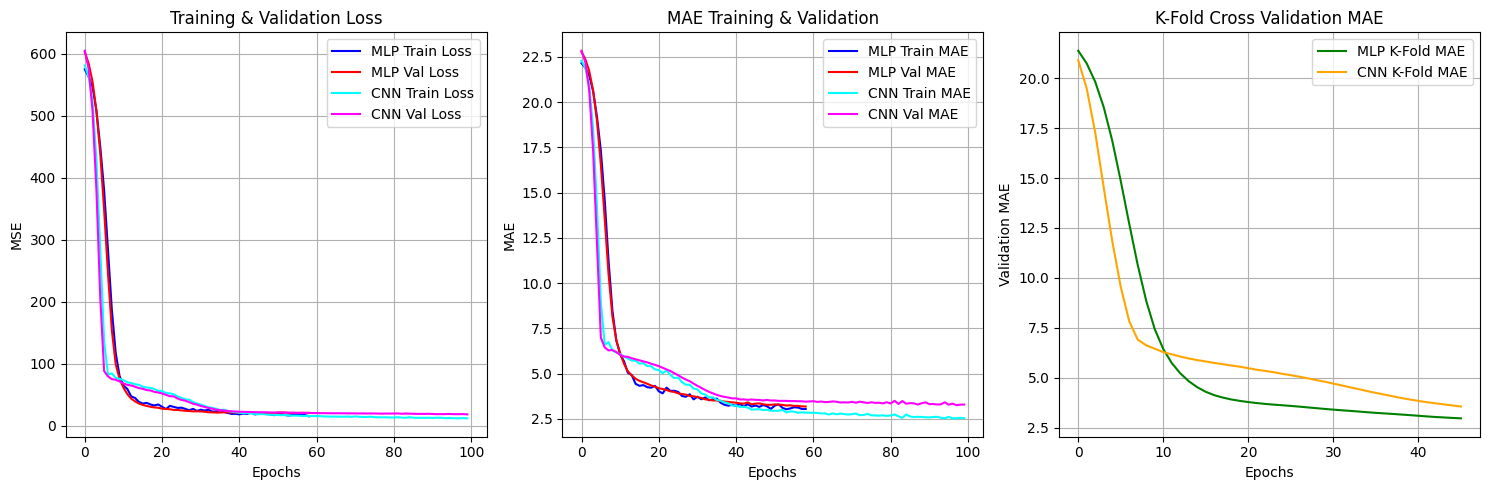


=== So sánh dự đoán vs thực tế (MLP) ===
Mẫu 1: Dự đoán=7.59, Thực tế=7.20, Difference=0.39
Mẫu 2: Dự đoán=16.51, Thực tế=18.80, Difference=2.29
Mẫu 3: Dự đoán=21.55, Thực tế=19.00, Difference=2.55
Mẫu 4: Dự đoán=35.12, Thực tế=27.00, Difference=8.12
Mẫu 5: Dự đoán=25.87, Thực tế=22.20, Difference=3.67

=== So sánh dự đoán vs thực tế (CNN) ===
Mẫu 1: Dự đoán=8.84, Thực tế=7.20, Difference=1.64
Mẫu 2: Dự đoán=15.59, Thực tế=18.80, Difference=3.21
Mẫu 3: Dự đoán=21.36, Thực tế=19.00, Difference=2.36
Mẫu 4: Dự đoán=35.74, Thực tế=27.00, Difference=8.74
Mẫu 5: Dự đoán=23.85, Thực tế=22.20, Difference=1.65


In [9]:
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import boston_housing

# Tắt eager execution để chạy ở graph mode (TensorFlow 1.x style)
tf.disable_eager_execution()

# 1. Load và chuẩn hóa dữ liệu
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

# Cho CNN: reshape thành (samples, timesteps, channels)
train_data_cnn = np.expand_dims(train_data, -1)
test_data_cnn = np.expand_dims(test_data, -1)

# 2. Định nghĩa DenseLayer
class DenseLayer(tf.Module):
    def __init__(self, units, activation=None, name=None):
        super().__init__(name=name)
        self.units = units
        self.activation = activation
        self.weights = None
        self.biases = None
    def build(self, input_dim):
        self.weights = tf.Variable(tf.random.normal([input_dim, self.units], stddev=0.1), dtype=tf.float32)
        self.biases = tf.Variable(tf.zeros([self.units]), dtype=tf.float32)
    def __call__(self, x):
        if self.weights is None:
            input_dim = int(x.shape[1])
            self.build(input_dim)
        out = tf.matmul(x, self.weights) + self.biases
        if self.activation:
            return self.activation(out)
        return out

# 3. MLP Model
def build_model_mlp(input_shape):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, input_shape], name='x')
    y_true = tf.placeholder(tf.float32, [None], name='y_true')
    is_training = tf.placeholder(tf.bool, name='is_training')
    w1 = tf.Variable(tf.random.normal([input_shape, 64], stddev=0.1))
    b1 = tf.Variable(tf.zeros([64]))
    h1 = tf.nn.relu(tf.matmul(x, w1) + b1)
    h1_dropout = tf.cond(is_training, lambda: tf.nn.dropout(h1, rate=0.3), lambda: h1)
    w2 = tf.Variable(tf.random.normal([64, 32], stddev=0.1))
    b2 = tf.Variable(tf.zeros([32]))
    h2 = tf.nn.relu(tf.matmul(h1_dropout, w2) + b2)
    w3 = tf.Variable(tf.random.normal([32, 1], stddev=0.1))
    b3 = tf.Variable(tf.zeros([1]))
    y_pred = tf.squeeze(tf.matmul(h2, w3) + b3)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    l2_loss = 0.01 * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3))
    total_loss = mse_loss + l2_loss
    mae_metric = tf.reduce_mean(tf.abs(y_true - y_pred))
    train_op = tf.train.AdamOptimizer(0.001).minimize(total_loss)
    return x, y_true, is_training, y_pred, total_loss, mae_metric, train_op

# 4. CNN custom Model
class Conv1DLayer(tf.Module):
    def __init__(self, filters, kernel_size, activation):
        super().__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.weights = tf.Variable(tf.random.normal([kernel_size, 1, filters], stddev=0.1))
        self.biases = tf.Variable(tf.zeros([filters]))
    def __call__(self, x):
        x = tf.nn.conv1d(x, self.weights, stride=1, padding="SAME")
        x = tf.nn.bias_add(x, self.biases)
        return self.activation(x)

class MaxPooling1DLayer(tf.Module):
    def __init__(self, pool_size):
        super().__init__()
        self.pool_size = pool_size
    def __call__(self, x):
        return tf.nn.pool(x, window_shape=[self.pool_size], pooling_type="MAX",
                          padding="SAME", strides=[self.pool_size])

class FlattenLayer(tf.Module):
    def __call__(self, x):
        shape = tf.shape(x)
        return tf.reshape(x, [shape[0], -1])

class CustomCNNModel(tf.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv1DLayer(32, 3, tf.nn.relu)
        self.pool1 = MaxPooling1DLayer(2)
        self.conv2 = Conv1DLayer(64, 3, tf.nn.relu)
        self.pool2 = MaxPooling1DLayer(2)
        self.flatten = FlattenLayer()
        self.dense1 = DenseLayer(64, tf.nn.relu)
        self.dense2 = DenseLayer(1)
    def __call__(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        if self.dense1.weights is None:
            self.dense1.build(4 * 64)  # Điều chỉnh kích thước đầu vào
        x = self.dense1(x)
        if self.dense2.weights is None:
            self.dense2.build(64)
        x = self.dense2(x)
        return x

def build_model_cnn(input_shape):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, input_shape[0], input_shape[1]], name='x')
    y_true = tf.placeholder(tf.float32, [None], name='y_true')
    is_training = tf.placeholder(tf.bool, name='is_training')
    model = CustomCNNModel()
    y_pred = tf.squeeze(model(x))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    total_loss = mse_loss
    mae_metric = tf.reduce_mean(tf.abs(y_true - y_pred))
    train_op = tf.train.AdamOptimizer(0.001).minimize(total_loss)
    return x, y_true, is_training, y_pred, total_loss, mae_metric, train_op

# 5. Training function with logging
def train_model(sess, x, y_true, is_training, train_op, total_loss, mae_metric, y_pred,
                train_data, train_targets, val_data, val_targets, epochs=100, batch_size=32, patience=10):
    n = len(train_data)
    history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        indices = np.random.permutation(n)
        train_data_shuffled = train_data[indices]
        targets_shuffled = train_targets[indices]
        epoch_losses, epoch_maes = [], []
        for i in range(0, n, batch_size):
            x_batch = train_data_shuffled[i:i+batch_size]
            y_batch = targets_shuffled[i:i+batch_size]
            _, loss, mae = sess.run([train_op, total_loss, mae_metric],
                                    feed_dict={x: x_batch, y_true: y_batch, is_training: True})
            epoch_losses.append(loss)
            epoch_maes.append(mae)
        val_loss, val_mae = sess.run([total_loss, mae_metric], 
                                     feed_dict={x: val_data, y_true: val_targets, is_training: False})
        history['loss'].append(np.mean(epoch_losses))
        history['val_loss'].append(val_loss)
        history['mae'].append(np.mean(epoch_maes))
        history['val_mae'].append(val_mae)
        # Log mỗi 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss={np.mean(epoch_losses):.4f}, val_loss={val_loss:.4f}, val_mae={val_mae:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping tại epoch {epoch}")
                break
    return history

# 6. K-Fold Cross Validation with logging
def k_fold_validation(k, data, targets, build_fn, num_epochs=50):
    fold_size = len(data) // k
    all_val_mae = []
    for i in range(k):
        print(f"\n--- Fold {i+1}/{k} ---")
        val_data = data[i * fold_size:(i + 1) * fold_size]
        val_targets = targets[i * fold_size:(i + 1) * fold_size]
        train_data_fold = np.concatenate([data[:i * fold_size], data[(i + 1) * fold_size:]], axis=0)
        train_targets_fold = np.concatenate([targets[:i * fold_size], targets[(i + 1) * fold_size:]], axis=0)
        x, y_true, is_training, y_pred, total_loss, mae_metric, train_op = build_fn(data.shape[1] if len(data.shape) == 2 else (data.shape[1], data.shape[2]))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            history = train_model(sess, x, y_true, is_training, train_op, total_loss, mae_metric, y_pred,
                                  train_data_fold, train_targets_fold, val_data, val_targets, epochs=num_epochs)
            all_val_mae.append(history['val_mae'])
    min_len = min(len(h) for h in all_val_mae)
    trimmed = [h[:min_len] for h in all_val_mae]
    return np.mean(trimmed, axis=0)

# 7. Train MLP
print("\n=== Train MLP ===")
x_mlp, y_true_mlp, is_training_mlp, y_pred_mlp, total_loss_mlp, mae_mlp, train_op_mlp = build_model_mlp(train_data.shape[1])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    history_mlp = train_model(sess, x_mlp, y_true_mlp, is_training_mlp, train_op_mlp, total_loss_mlp, mae_mlp, y_pred_mlp,
                              train_data, train_targets, test_data, test_targets, epochs=100)
    test_mae_mlp = sess.run(mae_mlp, feed_dict={x_mlp: test_data, y_true_mlp: test_targets, is_training_mlp: False})
    test_predictions_mlp = sess.run(y_pred_mlp, feed_dict={x_mlp: test_data, is_training_mlp: False})
    print(f"\nDự đoán cho ngôi nhà đầu tiên: {test_predictions_mlp[0]:.2f} (nghìn USD)")
    print(f"MAE trên tập kiểm tra cuối cùng: {test_mae_mlp:.4f}")

# K-Fold MLP
print("\n=== K-Fold Validation MLP ===")
average_mae_mlp = k_fold_validation(4, train_data, train_targets, build_model_mlp, num_epochs=50)

# 8. Train CNN
print("\n=== Train CNN ===")
x_cnn, y_true_cnn, is_training_cnn, y_pred_cnn, total_loss_cnn, mae_cnn, train_op_cnn = build_model_cnn((train_data_cnn.shape[1], train_data_cnn.shape[2]))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    history_cnn = train_model(sess, x_cnn, y_true_cnn, is_training_cnn, train_op_cnn, total_loss_cnn, mae_cnn, y_pred_cnn,
                              train_data_cnn, train_targets, test_data_cnn, test_targets, epochs=100)
    test_mae_cnn = sess.run(mae_cnn, feed_dict={x_cnn: test_data_cnn, y_true_cnn: test_targets, is_training_cnn: False})
    test_predictions_cnn = sess.run(y_pred_cnn, feed_dict={x_cnn: test_data_cnn, is_training_cnn: False})
    print(f"\nDự đoán cho ngôi nhà đầu tiên: {test_predictions_cnn[0]:.2f} (nghìn USD)")
    print(f"MAE trên tập kiểm tra cuối cùng: {test_mae_cnn:.4f}")

# K-Fold CNN
print("\n=== K-Fold Validation CNN ===")
average_mae_cnn = k_fold_validation(4, train_data_cnn, train_targets, build_model_cnn, num_epochs=50)

# 9. Visualization
plt.figure(figsize=(15, 5))
# Loss curves
plt.subplot(1, 3, 1)
plt.plot(history_mlp['loss'], label='MLP Train Loss', color='blue')
plt.plot(history_mlp['val_loss'], label='MLP Val Loss', color='red')
plt.plot(history_cnn['loss'], label='CNN Train Loss', color='cyan')
plt.plot(history_cnn['val_loss'], label='CNN Val Loss', color='magenta')
plt.xlabel('Epochs'); plt.ylabel('MSE'); plt.title('Training & Validation Loss')
plt.legend(); plt.grid(True)
# MAE curves
plt.subplot(1, 3, 2)
plt.plot(history_mlp['mae'], label='MLP Train MAE', color='blue')
plt.plot(history_mlp['val_mae'], label='MLP Val MAE', color='red')
plt.plot(history_cnn['mae'], label='CNN Train MAE', color='cyan')
plt.plot(history_cnn['val_mae'], label='CNN Val MAE', color='magenta')
plt.xlabel('Epochs'); plt.ylabel('MAE'); plt.title('MAE Training & Validation')
plt.legend(); plt.grid(True)
# K-Fold MAE
plt.subplot(1, 3, 3)
if len(average_mae_mlp) > 5:
    plt.plot(np.convolve(average_mae_mlp, np.ones(5)/5, mode='valid'), label='MLP K-Fold MAE', color='green')
    plt.plot(np.convolve(average_mae_cnn, np.ones(5)/5, mode='valid'), label='CNN K-Fold MAE', color='orange')
else:
    plt.plot(average_mae_mlp, label='MLP K-Fold MAE', color='green')
    plt.plot(average_mae_cnn, label='CNN K-Fold MAE', color='orange')
plt.xlabel('Epochs'); plt.ylabel('Validation MAE'); plt.title('K-Fold Cross Validation MAE')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# 10. So sánh dự đoán vs thực tế (5 mẫu)
print("\n=== So sánh dự đoán vs thực tế (MLP) ===")
for i in range(5):
    print(f"Mẫu {i+1}: Dự đoán={test_predictions_mlp[i]:.2f}, Thực tế={test_targets[i]:.2f}, Difference={abs(test_predictions_mlp[i] - test_targets[i]):.2f}")
print("\n=== So sánh dự đoán vs thực tế (CNN) ===")
for i in range(5):
    print(f"Mẫu {i+1}: Dự đoán={test_predictions_cnn[i]:.2f}, Thực tế={test_targets[i]:.2f}, Difference={abs(test_predictions_cnn[i] - test_targets[i]):.2f}")